In [ ]:
pip install surprise

     |████████████████████████████████| 11.8MB 288kB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1617551 sha256=552961e73cb4974ba6ee39279ef2b90a4a14234d5c2c103ef4c5c15f925332c6
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


In [ ]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from matplotlib.pyplot import figure
from PIL import Image
import requests
from io import BytesIO
import os
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from scipy import sparse
import re

import warnings
warnings.simplefilter("ignore")

In [ ]:
#preprocessed training dataset
url1 = "../dataset/train.csv"
train_data = pd.read_csv(url1)
train_data

,fit,user_id,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,bust_size,bust_type
0,small,379417,658706,120.000000,10.0,party,"It ran a little small, in my opinion, but the ...",straight & narrow,"Perfect, Unique Dress!",dress,65.0,M,34.0,34.0,b
1,fit,904971,182915,120.000000,10.0,party,Wore this to a Christmas party - so comfortabl...,straight & narrow,Great fit and material!,dress,64.0,S,52.0,34.0,b
2,small,163215,1979533,150.000000,10.0,other,As the temperatures climbed into the 90s yeste...,hourglass,Bright and fun for engagement pics!,dress,69.0,S,28.0,34.0,d
3,small,232640,880935,140.000000,8.0,wedding,The dress color was a wow! I found the dress ...,hourglass,This dress is a standout!,dress,68.0,M,38.0,34.0,c
4,fit,691117,180014,137.391709,10.0,party,"This dress is very flattering, and the cutouts...",athletic,So easy to wear and comfy! Paired with red acc...,dress,69.0,L,33.0,34.0,b
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154030,small,733207,2358935,128.000000,8.0,work,This was a cute top. I really liked the lace a...,athletic,Fun Top.,top,66.0,S,38.0,32.0,dd
154031,fit,873762,625911,160.000000,10.0,wedding,This dress was great! The style of the dress i...,athletic,"Classic design, with an edge.",dress,68.0,XL,27.0,36.0,b
154032,fit,14227,1515649,145.000000,8.0,party,no complaints,pear,fit like a glove,dress,65.0,M,37.0,32.0,d
154033,fit,421813,127081,170.000000,8.0,wedding,The fit of the dress is pretty true to size. I...,hourglass,Cancelled wedding. but gorgeous dress,gown,66.0,XL,34.0,36.0,d


In [ ]:
#preprocessed test dataset
url2 = "../dataset/test.csv"
test_data = pd.read_csv(url2)
test_data

,fit,user_id,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,bust_size,bust_type
0,fit,492205,208647,115.000000,8.0,wedding,"I rented this dress for my mom, she loved it! ...",straight & narrow,Great Dress for a wedding!,dress,66.0,XL,25.0,32.0,d
1,fit,596658,145906,135.000000,8.0,wedding,"I was at a winter, black tie wedding, a lot of...",athletic,Received a lot of compliments,gown,65.0,S,31.0,36.0,c
2,fit,88342,1740815,135.000000,10.0,work,Fabulous black & white dress by Carven! We lov...,hourglass,Stylist Review!,dress,65.0,XL,29.0,34.0,c
3,fit,501057,2803807,110.000000,10.0,everyday,good fit,petite,looks great,jacket,63.0,XS,34.0,30.0,b
4,fit,662466,2521411,137.391709,8.0,party,It's a cute jacket that I wore a few times - b...,straight & narrow,Cute but not amazing,jacket,68.0,S,27.0,34.0,c
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38504,fit,884008,172027,105.000000,10.0,date,Slightly loose in the top but was absolutely f...,petite,Amazing outfit to go see Hamilton!,dress,64.0,XS,31.0,34.0,a
38505,large,437160,130259,137.391709,8.0,wedding,Dress was a beautiful color but it just didn't...,full bust,Didn't work out:(,dress,62.0,L,50.0,34.0,c
38506,fit,425211,416213,137.391709,8.0,wedding,Open back means no bra (which I usually never ...,full bust,Perfect for a fall wedding!,gown,62.0,XL,30.0,38.0,d
38507,large,970560,1146825,123.000000,10.0,everyday,"Lose fit, Very comfortable, Wear any color sh...",petite,"Overall the dress, although a little lose fitt...",dress,64.0,XS,36.0,32.0,a


In [ ]:
#for the train data - list out all users to avoid duplicate users and place an index to each user.
user_ids_train = train_data["user_id"].unique().tolist()

#index all the unique users
user2user_encoded_train = {x: i for i, x in enumerate(user_ids_train)}
#print(user2user_encoded_train)

userencoded2user_train = {i: x for i, x in enumerate(user_ids_train)}
#print(userencoded2user_train)

In [ ]:
#for the test data - list out all users to avoid duplicate users and place an index to each user.
user_ids_test = test_data["user_id"].unique().tolist()

#index all the unique users
user2user_encoded_test = {x: i for i, x in enumerate(user_ids_test)}
#print(user2user_encoded_test)

userencoded2user_test = {i: x for i, x in enumerate(user_ids_test)}
#print(userencoded2user_test)

In [ ]:
#for the train data - list out all items, to avoid duplicate items and place an index to each items.
item_ids_train = train_data["item_id"].unique().tolist()

item2item_encoded_train = {x: i for i, x in enumerate(item_ids_train)}
#print(item2item_encoded_train)

itemencoded2item_train = {i: x for i, x in enumerate(item_ids_train)}
#print(itemencoded2item_train)

In [ ]:
#for the test data - list out all items, to avoid duplicate items and place an index to each items.
item_ids_test = test_data["item_id"].unique().tolist()

item2item_encoded_test = {x: i for i, x in enumerate(item_ids_test)}
#print(item2item_encoded_test)

itemencoded2item_test= {i: x for i, x in enumerate(item_ids_test)}
#print(itemencoded2item_test)

In [ ]:
#mapping back to the train_data dataframe
train_data["userfind"] = train_data["user_id"].map(user2user_encoded_train)
train_data["itemfind"] = train_data["item_id"].map(item2item_encoded_train)
print (train_data)

          fit  user_id  item_id  ...  bust_type  userfind itemfind
0       small   379417   658706  ...          b         0        0
1         fit   904971   182915  ...          b         1        1
2       small   163215  1979533  ...          d         2        2
3       small   232640   880935  ...          c         3        3
4         fit   691117   180014  ...          b         4        4
...       ...      ...      ...  ...        ...       ...      ...
154030  small   733207  2358935  ...         dd      3432       70
154031    fit   873762   625911  ...          b     90410     4506
154032    fit    14227  1515649  ...          d     71444      522
154033    fit   421813   127081  ...          d     90411       56
154034    fit   902767   126335  ...          b     90412      230

[154035 rows x 17 columns]


In [ ]:
#mapping back to the test_data dataframe
test_data["userfind"] = test_data["user_id"].map(user2user_encoded_test)
test_data["itemfind"] = test_data["item_id"].map(item2item_encoded_test)
print (test_data)

         fit  user_id  item_id  ...  bust_type  userfind itemfind
0        fit   492205   208647  ...          d         0        0
1        fit   596658   145906  ...          c         1        1
2        fit    88342  1740815  ...          c         2        2
3        fit   501057  2803807  ...          b         3        3
4        fit   662466  2521411  ...          c         4        4
...      ...      ...      ...  ...        ...       ...      ...
38504    fit   884008   172027  ...          a     30580      346
38505  large   437160   130259  ...          c     30581      123
38506    fit   425211   416213  ...          d     13793      523
38507  large   970560  1146825  ...          a     30582      406
38508  small    30013   132738  ...          c      1476       45

[38509 rows x 17 columns]


In [ ]:
#preparing train set
num_users_train = len(user2user_encoded_train)
num_items_train = len(itemencoded2item_train)

train_data["rating"] = train_data["rating"].values.astype(np.float32)

# min and max ratings will be used to normalize the ratings later
min_rating = min(train_data["rating"])
max_rating = max(train_data["rating"])

print(
    "Number of users in train data: {}, Number of items in train data: {}, Min rating: {}, Max rating: {}".
     format(num_users_train, num_items_train, min_rating, max_rating)
)

Number of users in train data: 90413, Number of items in train data: 5762, Min rating: 2.0, Max rating: 10.0


In [ ]:
#Prepare training and validation dataset

x = train_data[["userfind", "itemfind"]].values

# Normalize the targets between 0 and 1. Makes it easy to train.
y = train_data["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# Assuming training on 80% of the data and validating on 20%.
train_indices = int(0.80 * train_data.shape[0])  #take 80% of the rows as training data

x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

### Neural network based CF

In [ ]:
from surprise import Dataset
from surprise import Reader
from surprise import BaselineOnly

import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from surprise import accuracy

Reference: https://towardsdatascience.com/movie-recommender-system-a5dbfdb2585d

he_normal> It draws samples from a truncated normal distribution centered on 0 with stddev = sqrt(2 / fan_in) where fan_in is the number of input units in the weight tensor.

EMBEDDING_SIZE>  Embedding is the concept of mapping from discrete objects such as words to vectors and real numbers. 
Keras offers an Embedding layer that can be used for neural networks on text data. It requires that the input data be integer encoded, so that each word is represented by a unique integer. This data preparation step can be performed using the Tokenizer API also provided with Keras.
There are a few different embedding vector sizes, including 50, 100, 200 and 300 dimensions. You can download this collection of embeddings and we can seed the Keras Embedding layer with weights from the pre-trained embedding for the words in your training dataset.

In [ ]:
#defined the embedding layer size
EMBEDDING_SIZE = 100


class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_items, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_size = embedding_size
        #doing embedding on user
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        
        
        #doing embedding on item
        self.items_embedding = layers.Embedding(
            num_items,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.items_bias = layers.Embedding(num_items, 1)

        
    def call(self, inputs):
        #preparing user vectors and item vectors
        user_vector = self.user_embedding(inputs[:, 0]) 
        user_bias = self.user_bias(inputs[:, 0])  
        items_vector = self.items_embedding(inputs[:, 1])
        items_bias = self.items_bias(inputs[:, 1])  
        
        #dot product of vectors
        dot_user_items = tf.tensordot(user_vector, items_vector, 2)
        
        x = dot_user_items + user_bias + items_bias
        # normalized rating
        return tf.nn.sigmoid(x)

model = RecommenderNet(num_users_train, num_items_train, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=0.001)
)

In [ ]:
#calculating the loss
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=500,
    epochs=10,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/10
247/247 [==============================] - 23s 86ms/step - loss: 0.6796 - val_loss: 0.5835
Epoch 2/10
247/247 [==============================] - 21s 84ms/step - loss: 0.6457 - val_loss: 0.6192
Epoch 3/10
247/247 [==============================] - 21s 84ms/step - loss: 0.3662 - val_loss: 0.6171
Epoch 4/10
247/247 [==============================] - 21s 84ms/step - loss: 0.3537 - val_loss: 0.6212
Epoch 5/10
247/247 [==============================] - 21s 84ms/step - loss: 0.3536 - val_loss: 0.6234
Epoch 6/10
247/247 [==============================] - 21s 84ms/step - loss: 0.3507 - val_loss: 0.6247
Epoch 7/10
247/247 [==============================] - 21s 84ms/step - loss: 0.3516 - val_loss: 0.6283
Epoch 8/10
247/247 [==============================] - 21s 84ms/step - loss: 0.3541 - val_loss: 0.6322
Epoch 9/10
247/247 [==============================] - 21s 85ms/step - loss: 0.3627 - val_loss: 0.6303
Epoch 10/10
247/247 [==============================] - 21s 85ms/step - loss: 0.398

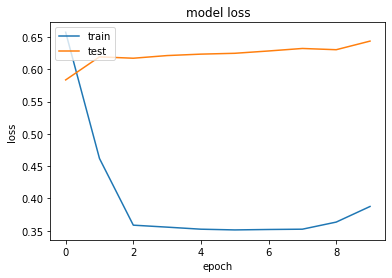

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()


In [ ]:
#evaluation by MSE, MAE
model = RecommenderNet(num_users_train, num_items_train, EMBEDDING_SIZE)
model.compile(
    keras.optimizers.Adam(lr=0.001), loss="mean_squared_error",
    metrics=["mean_absolute_error", "mean_squared_error"])

In [ ]:
#calculating the errors
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=100,
    epochs=5,
    verbose=1,
    validation_data=(x_val, y_val),
)


Epoch 1/5
1233/1233 [==============================] - 104s 83ms/step - loss: 0.1660 - mean_absolute_error: 0.3795 - mean_squared_error: 0.1652 - val_loss: 0.0685 - val_mean_absolute_error: 0.2212 - val_mean_squared_error: 0.0640
Epoch 2/5
1233/1233 [==============================] - 103s 83ms/step - loss: 0.0488 - mean_absolute_error: 0.1144 - mean_squared_error: 0.0444 - val_loss: 0.0713 - val_mean_absolute_error: 0.2280 - val_mean_squared_error: 0.0672
Epoch 3/5
1233/1233 [==============================] - 103s 84ms/step - loss: 0.0481 - mean_absolute_error: 0.1151 - mean_squared_error: 0.0441 - val_loss: 0.0994 - val_mean_absolute_error: 0.2831 - val_mean_squared_error: 0.0960
Epoch 4/5
1233/1233 [==============================] - 103s 83ms/step - loss: 0.0355 - mean_absolute_error: 0.1434 - mean_squared_error: 0.0321 - val_loss: 0.1101 - val_mean_absolute_error: 0.3010 - val_mean_squared_error: 0.1067
Epoch 5/5
1233/1233 [==============================] - 102s 83ms/step - loss: 0.

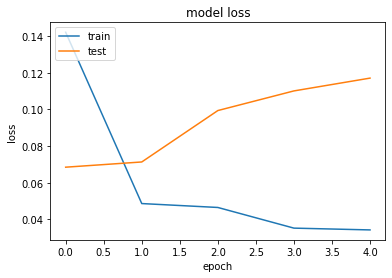

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

 # Recommendation: Top 10 items

In [ ]:
# what a user has already reviewed

user_selected = test_data.user_id.sample(1).iloc[0]  
items_reviewed_by_user = test_data[test_data.user_id == user_selected ]
print(items_reviewed_by_user)

         fit  user_id  item_id  ...  bust_type  userfind itemfind
31538  large   294098   887454  ...          c     25767      277

[1 rows x 17 columns]


In [ ]:
#what a user has not already reviewed
items__not_reviewed = test_data[~test_data["item_id"].isin(items_reviewed_by_user.item_id.values)]["item_id"]

items__not_reviewed = list(set(items__not_reviewed).intersection(set(item2item_encoded_test.keys())))

items__not_reviewed = [[item2item_encoded_test.get(x)] for x in items__not_reviewed]

user_encoder = user2user_encoded_test.get(user_selected)

#Stack arrays in sequence horizontally (column wise).
user_item_array = np.hstack(([[user_encoder]] * len(items__not_reviewed), items__not_reviewed))  #user_item_array consists of selected_user in userfind and itemfind

rate = model.predict(user_item_array)
ratings = model.predict(user_item_array).flatten()


#For any iterable in python [-10:] denotes the indexing of last 10 items of that iterable.
#[::-1] denotes same list in reverse order
#returns top 10 max ratings' indices
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_item_ids = [
    itemencoded2item_test.get(items__not_reviewed[x][0]) for x in top_ratings_indices
]

In [ ]:
print(user_item_array)
print(rate)

[[25767   592]
 [25767   722]
 [25767  4164]
 ...
 [25767  4204]
 [25767  4148]
 [25767  4100]]
[[0.5744927 ]
 [0.56738025]
 [0.50355405]
 ...
 [0.49205014]
 [0.53062665]
 [0.5303261 ]]


In [ ]:
print (top_ratings_indices)

[ 935 2846   17 3925  133  101 2445 2207 2824  430]


In [ ]:
#Top 10 recommended items 
print("Showing recommendations for user: {}".format(user_selected))

print("Top 10 items recommendations")

recommended_items = test_data[test_data["item_id"].isin(recommended_item_ids)]
recommended_items = recommended_items.drop_duplicates(subset = ["item_id"])

for row in recommended_items.itertuples():
    print(row.item_id)

Showing recommendations for user: 294098
Top 10 items recommendations
492247
164051
864299
168610
165468
1325648
561864
1941671
1736728
1134208
